<a href="https://colab.research.google.com/github/Allen123321/DEMO-DL/blob/master/015_Data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Overview
This tutorial demonstrates data augmentation: a technique to increase the diversity of your training set by applying random (but realistic) transformations such as image rotation. You will learn how to apply data augmentation in two ways. First, you will use Keras Preprocessing Layers. Next, you will use tf.image.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

### Download a dataset
This tutorial uses the tf_flowers dataset. For convenience, download the dataset using TensorFlow Datasets. If you would like to learn about others ways of importing data, see the load images tutorial.

In [2]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [3]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


In [4]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))


In [5]:
label

<tf.Tensor: shape=(), dtype=int64, numpy=2>

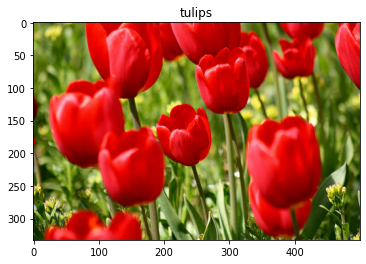

In [6]:
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

Use Keras preprocessing layers

Resizing and rescaling

You can use preprocessing layers to resize your images to a consistent shape, and to rescale pixel values.

In [7]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])

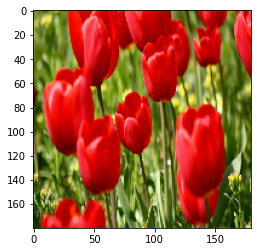

In [8]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [9]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


Data augmentation

You can use preprocessing layers for data augmentation as well.

Let's create a few preprocessing layers and apply them repeatedly to the same image.

In [10]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [11]:
# Add the image to a batch
image = tf.expand_dims(image, 0)

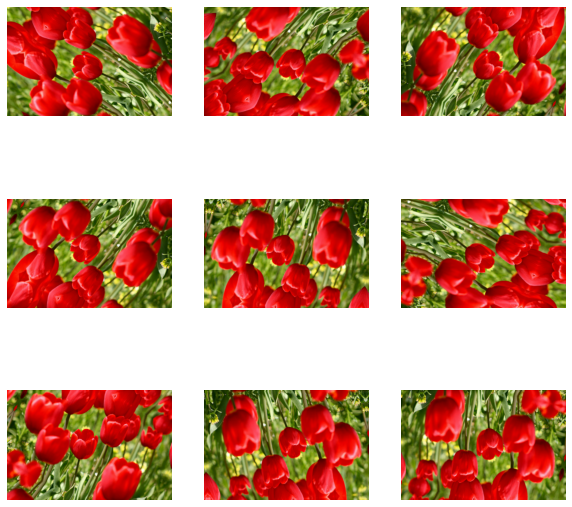

In [12]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

There are a variety of preprocessing layers you can use for data augmentation including layers.RandomContrast, layers.RandomCrop, layers.RandomZoom, and others.

Two options to use the preprocessing layers
There are two ways you can use these preprocessing layers, with important tradeoffs.

Option 1: Make the preprocessing layers part of your model


In [13]:
model = tf.keras.Sequential([
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model
])

There are two important points to be aware of in this case:

Data augmentation will run on-device, synchronously with the rest of your layers, and benefit from GPU acceleration.

When you export your model using model.save, the preprocessing layers will be saved along with the rest of your model. If you later deploy this model, it will automatically standardize images (according to the configuration of your layers). This can save you from the effort of having to reimplement that logic server-side.

Option 2: Apply the preprocessing layers to your dataset

In [14]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

With this approach, you use Dataset.map to create a dataset that yields batches of augmented images. In this case:

Data augmentation will happen asynchronously on the CPU, and is non-blocking. You can overlap the training of your model on the GPU with data preprocessing, using Dataset.prefetch, shown below.


In this case the prepreprocessing layers will not be exported with the model when you call model.save. You will need to attach them to your model before saving it or reimplement them server-side. After training, you can attach the preprocessing layers before export.

You can find an example of the first option in the image classification tutorial. Let's demonstrate the second option here.

Apply the preprocessing layers to the datasets

Configure the train, validation, and test datasets with the preprocessing layers you created above. You will also configure the datasets for performance, using parallel reads and buffered prefetching to yield batches from disk without I/O become blocking. You can learn more dataset performance in the Better performance with the tf.data API guide.

In [15]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

In [16]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

Train a model

For completeness, you will now train a model using these datasets. This model has not been tuned for accuracy (the goal is to show you the mechanics).

In [17]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 19s 124ms/step - loss: 1.8113 - accuracy: 0.3080 - val_loss: 1.1164 - val_accuracy: 0.5559
Epoch 2/5
92/92 [==============================] - 10s 100ms/step - loss: 1.1479 - accuracy: 0.5071 - val_loss: 1.0548 - val_accuracy: 0.5858
Epoch 3/5
92/92 [==============================] - 10s 98ms/step - loss: 1.0755 - accuracy: 0.5677 - val_loss: 1.0320 - val_accuracy: 0.6158
Epoch 4/5
92/92 [==============================] - 10s 100ms/step - loss: 1.0060 - accuracy: 0.6079 - val_loss: 1.1157 - val_accuracy: 0.5668
Epoch 5/5
92/92 [==============================] - 10s 99ms/step - loss: 0.9857 - accuracy: 0.6117 - val_loss: 0.9839 - val_accuracy: 0.6104


In [20]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

12/12 [==============================] - 1s 40ms/step - loss: 0.9360 - accuracy: 0.6213
Accuracy 0.6212534308433533


Custom data augmentation

You can also create custom data augmenation layers. This tutorial shows two ways of doing so. First, you will create a layers.Lambda layer. This is a good way to write concise code. Next, you will write a new layer via subclassing, which gives you more control. Both layers will randomly invert the colors in an image, according to some probability.

In [21]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

In [22]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

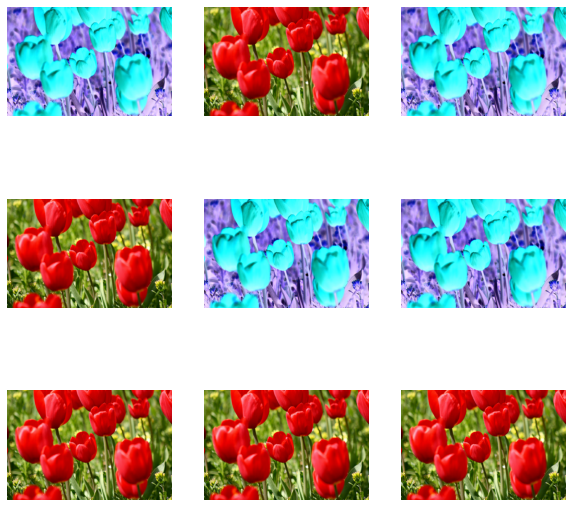

In [23]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

Next, implement a custom layer by subclassing.

In [24]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

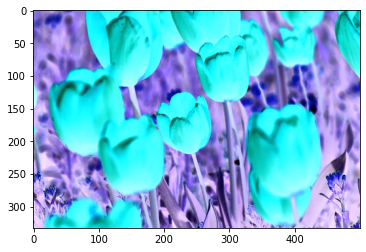

In [25]:
_ = plt.imshow(RandomInvert()(image)[0])

Using tf.image

The above layers.preprocessing utilities are convenient. For finer control, you can write your own data augmentation pipelines or layers using tf.data and tf.image. You may also want to check out TensorFlow Addons Image: Operations and TensorFlow I/O: Color Space Conversions

Since the flowers dataset was previously configured with data augmentation, let's reimport it to start fresh.

In [26]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Retrieve an image to work with

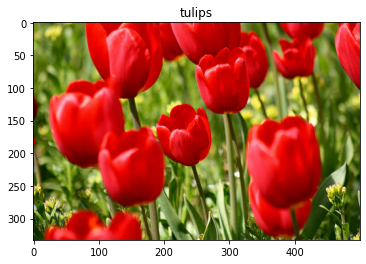

In [27]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

Let's use the following function to visualize and compare the original and augmented images side-by-side.

In [28]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

Data augmentation

Flipping the image

Flip the image either vertically or horizontally.

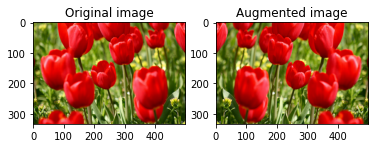

In [29]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

Grayscale the image

Grayscale an image.

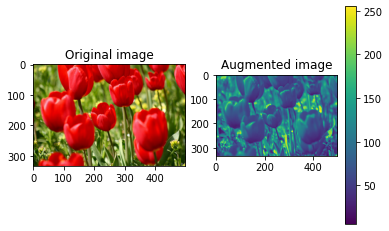

In [30]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

Saturate the image

Saturate an image by providing a saturation factor.

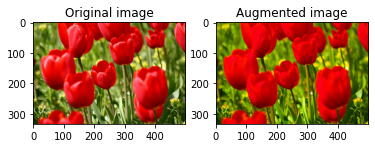

In [31]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

Change image brightness

Change the brightness of image by providing a brightness factor.

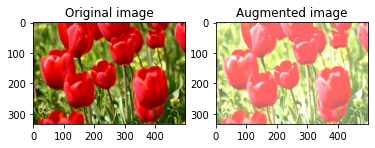

In [32]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

Center crop the image

Crop the image from center up to the image part you desire.

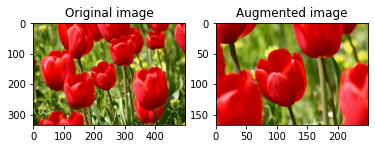

In [33]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image,cropped)

Rotate the image

Rotate an image by 90 degrees.

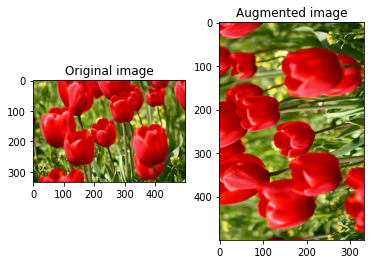

In [34]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

Randomly change image brightness

Randomly change the brightness of image by providing a brightness factor and seed. The brightness factor is chosen randomly in the range [-max_delta, max_delta) and is associated with the given seed.

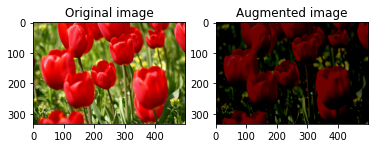

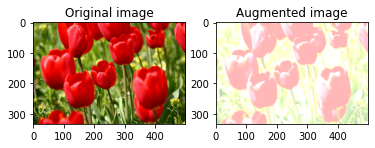

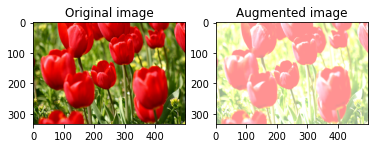

In [35]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_brightness = tf.image.stateless_random_brightness(
      image, max_delta=0.95, seed=seed)
  visualize(image, stateless_random_brightness)

Randomly change image contrast


Randomly change the contrast of image by providing a contrast range and seed. The contrast range is chosen randomly in the interval [lower, upper] and is associated with the given seed.

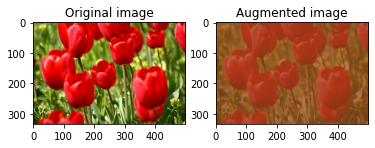

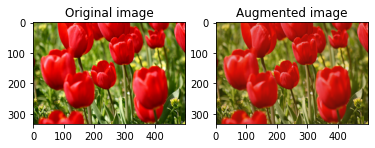

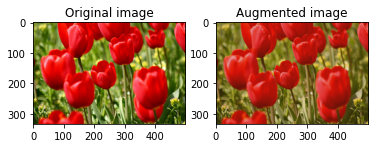

In [36]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_contrast = tf.image.stateless_random_contrast(
      image, lower=0.1, upper=0.9, seed=seed)
  visualize(image, stateless_random_contrast)

Randomly crop an image

Randomly crop image by providing target size and seed. The portion that gets cropped out of image is at a randomly chosen offet and is associated with the given seed.

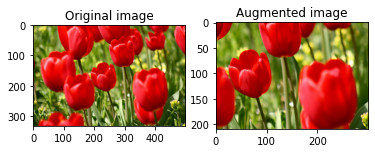

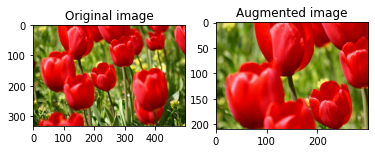

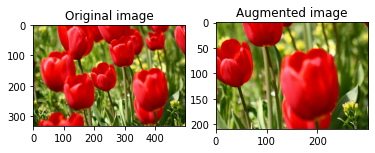

In [37]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_crop = tf.image.stateless_random_crop(
      image, size=[210, 300, 3], seed=seed)
  visualize(image, stateless_random_crop)

Apply augmentation to a dataset


Let's first download the image dataset again in case they are modified in the previous sections.

In [38]:
(train_datasets, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Let's define a utility function for resizing and rescaling the images. This function will be used in unifying the size and scale of images in the dataset:

In [39]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

Let's also define augment function that can apply the random transformations to the images. This function will be used on the dataset in the next step.

In [44]:
@tf.function
def augment(image_label, seed):
  image, label = image_label
  image, label = resize_and_rescale(image, label)
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
  # Make a new seed
  new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
  # Random crop back to the original size
  image = tf.image.stateless_random_crop(
      image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
  # Random brightness
  image = tf.image.stateless_random_brightness(
      image, max_delta=0.5, seed=new_seed)
  image = tf.clip_by_value(image, 0, 1)
  return image, label

Option 1: Using tf.data.experimental.Counter()

Create a tf.data.experimental.Counter() object (let's call it counter) and zip the dataset with (counter, counter). This will ensure that each image in the dataset gets associated with a unique value (of shape (2,)) based on counter which later can get passed into the augment function as the seed value for random transformations.

In [45]:
# Create counter and zip together with train dataset
counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((train_datasets, (counter, counter)))

Map the augment function to the training dataset.

In [46]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [47]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [48]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

Option 2: Using tf.random.Generator


Create a tf.random.Generator object with an intial seed value. Calling make_seeds function on the same generator object returns a new, unique seed value always. Define a wrapper function that 1) calls make_seeds function and that 2) passes the newly generated seed value into the augment function for random transformations.

In [49]:
# Create a generator
rng = tf.random.Generator.from_seed(123, alg='philox')

In [50]:
# A wrapper function for updating seeds
def f(x, y):
  seed = rng.make_seeds(2)[0]
  image, label = augment((x, y), seed)
  return image, label

In [51]:
train_ds = (
    train_datasets
    .shuffle(1000)
    .map(f, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [52]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [53]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)